### Objective :  
- In previous notebook we have learnt how to represent each word by a number.
- Now to build classification model we need to feed whole sentence into neural network.
- Here sentence has a variable length and neural networks deal with fixed input size.

### Solution of our problem :
There are two ways to convert a variable length to fixed input size
- Collapse a sentence into fixed-length vector using Bag-of-Words and TF-IDF representations.
- Design special neural network architectures that can deal with variable length sequences. 

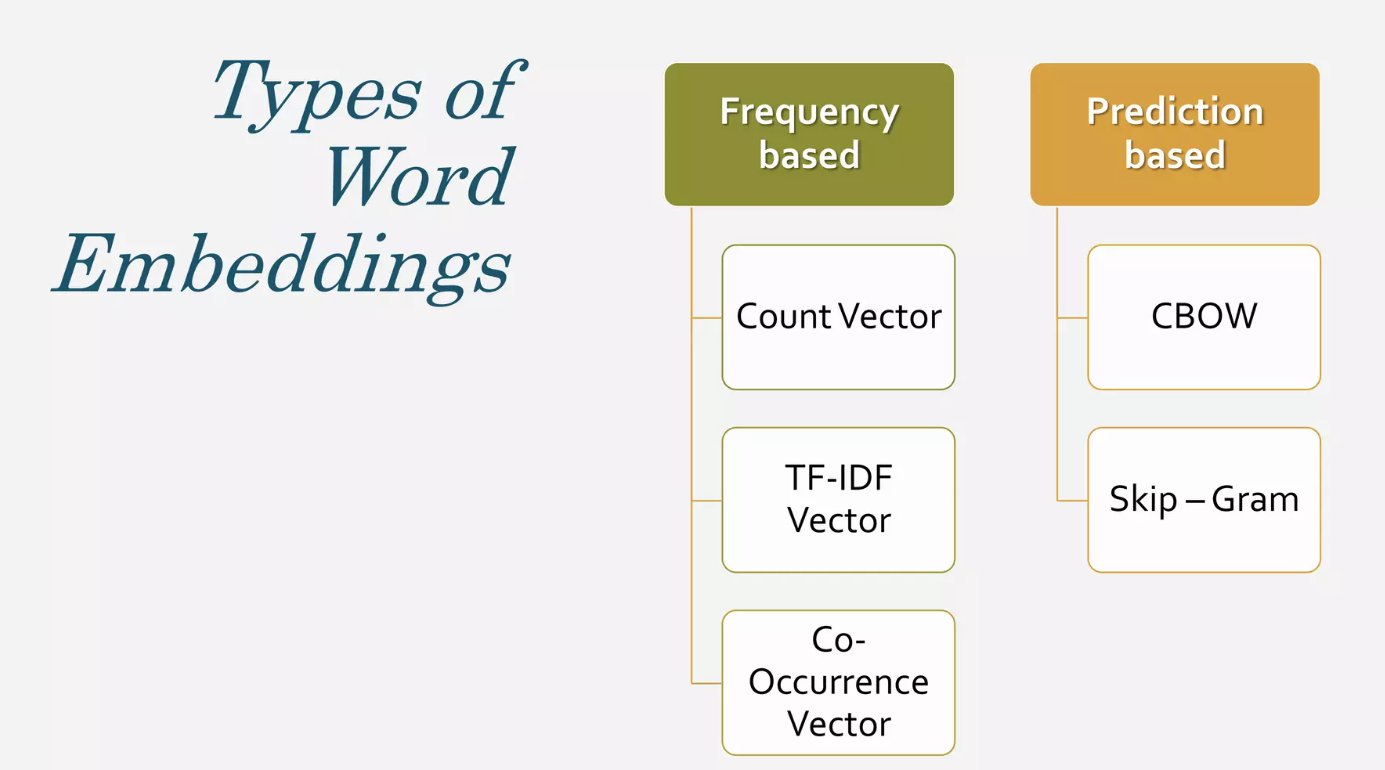

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/types.png')

In [2]:
import torchtext
import torch
import os
import collections
from custom_module import load_utilities
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

['World', 'Sports', 'Business', 'Sci/Tech']


In [3]:
train_dataset, test_dataset,classes = load_utilities()

In [4]:
counter = collections.Counter()
for (label,line) in train_dataset:
    #This step essentially counts the number of occurrences of each token in the entire training dataset.
    counter.update(tokenizer(line))
vocab = torchtext.vocab.Vocab(counter, min_freq=1)
vocab_size = len(vocab)
print(vocab_size)

95812


#### Bag of Words (BoW) 
- It is a method of representing text data as a numerical feature vector.
- The BoW model is based on the idea that a document can be represented as a "bag" of its words, ignoring the order of the words and focusing only on their frequencies in the document.

In [5]:
def encode(x):
    return [vocab.stoi[s] for s in tokenizer(x)]

In [6]:
def to_bow(text,bow_vocab_size=vocab_size):
    res = torch.zeros(bow_vocab_size,dtype=torch.float32)
    for i in encode(text):
        if i<bow_vocab_size:
            res[i] += 1
    return res

print(f"text:\n{train_dataset[0][1]}")
print(f"\nBoW vector:\n{to_bow(train_dataset[0][1])}")

text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

BoW vector:
tensor([0., 0., 2.,  ..., 0., 0., 0.])


#### Term Frequency-Inverse Document Frequency (tf-idf) 
- Numerical statistic used in NLP to evaluate the importance of words in a document within a large corpus.
- The tf-idf model takes into account both the frequency of a term within a document (term frequency) and the frequency of the term within the entire corpus (inverse document frequency).
- `Term frequency (TF)` measures how frequently a term occurs in a document, and is calculated using number of times a term appear in document divided by the total number of terms in document.
- `The inverse document frequency (IDF) ` measures how important a term is across entire corpus, and is calculated using total number of documents in the corpus divided by number of document containing that term.
-` tf-idf weight for a term in a document` = TF*IDF
- This weight reflects the importance of the term in the document relative to its importance in the corpus.

In [7]:
N = 1000
df = torch.zeros(vocab_size)
for _,line in train_dataset[:N]:
    for i in set(encode(line)):
        df[i] += 1

In [8]:
def tf_idf(s):
    bow = to_bow(s)
    return bow*torch.log((N+1)/(df+1))

print(tf_idf(train_dataset[0][1]))

tensor([0.0000, 0.0000, 0.0363,  ..., 0.0000, 0.0000, 0.0000])


#### Limitations of TFIDF :
- 1. It does not take into account word order
- 2. It is sensitive to corpus size
- 3. It does not account for synonyms
- 4. It can be biased towards rare terms

#### Dealing with variable sequence size

In [9]:
def pad_sequence(b):
    vector = [encode(x[1]) for x in b]
    max_length = max(map(len,vector))
    # tuple of two tensors - labels and features
    return ( # tuple of two tensors - labels and features
        torch.LongTensor([t[0]-1 for t in b]),
        torch.stack([torch.nn.functional.pad(torch.tensor(t),(0,max_length-len(t)),mode='constant',value=0) for t in vector])
    )
    

In [10]:
labels, features = pad_sequence(train_dataset)

#### Word embeddings
- Word embeddings are a type of dense, low-dimensional vector representation of words that capture the semantic and syntactic meaning of the words.
- By representing each word as a vector, we can perform mathematical operations on them and use them as input to neural network.

#### Dimensionality reduction techniques
- They are used to reduce the number of features in the input data while retaining as much relevant information as possible.
- They helps to reduce the computational complexity and memory requirements of a model.

##### By combining word embedding and dimensionality reduction techniques such as PCA or t- distributed stochastic neighbour embedding, we can create more efficient and effective representation of our text data.

#### Embedding Layer
- Embedding Layer would take a word as input and produce output vectoro of specified embedding size
- It is very similar to Linear layer, but instead of taking one-hot encoded vector, it will be able to take a word number as an input.

In [11]:
class EmbedClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.fc = torch.nn.Linear(embed_dim, num_class)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x,dim=1)
        return self.fc(x)

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=pad_sequence, shuffle=True)

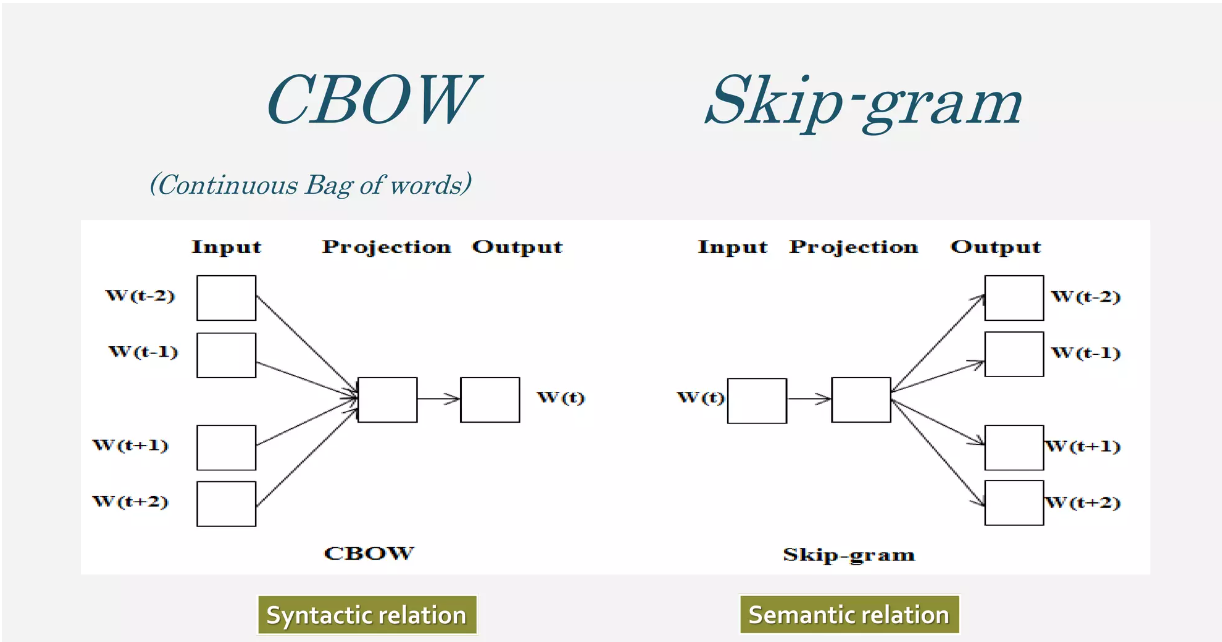

In [13]:
from IPython.display import Image
Image(filename='./images/diff.png')

#### Both CBOW and Skip-Grams are “predictive” embeddings, in that they only take local contexts into account. Word2Vec does not take advantage of global context.
#### Continuous Bag-of-Words
- The CBOW model tries to predict a target word given the surrounding context words in a sentence
- The context words are represented as one-hot vectors, and the target word is also represented as a one-hot vector.
- The CBOW model then learns to predict the target word by minimizing a loss function, which measures the difference between the predicted and actual target word vectors.

#### Skip-gram 
-  It takes as input a target word represented as a one-hot vector and learns to predict the context words by minimizing a loss function.
- The Skip-gram model has the advantage of being able to capture fine-grained semantic and syntactic relationships between words, as it tries to predict multiple context words for each target word.
- Skip-gram is computationally more expensive than CBOW and requires a larger amount of training data to learn effective word embeddings. It is also less effective in capturing the global context of a sentence

#### To take advantage of global context we use below
- **GloVe** (Global Vectors) - derives the relationship between words. It determines how often a particular word-pair occurs together in a text by leveraging the idea of co-occurence matrix and uses neural methods to decompose co-occurrence matrix into more expressive and non linear word vectors.
- **FastText** - builds on Word2Vec by learning vector representations for each word and the charachter n-grams found within each word. The values of the representations are then averaged into one vector at each training step. While this adds a lot of additional computation to pre-training, it enables word embeddings to encode sub-word information.
- **Gensim** (Generate Similar) - is an open source NLP Python library that provides a unified interface to build word vectors, corpus, perform topic identification, and other NLP tasks.

FastText and GloVe are other word embeddings techniques that predict the probably of words appearing together.  

#### Gensim
- To experiment with word2vec embedding pre-trained on Google News dataset, we can use the **gensim** library

In [14]:
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

#### words that are similar to 'monitor'.

In [15]:
w2v.most_similar('monitor')

[('monitoring', 0.7490496635437012),
 ('monitors', 0.7490357756614685),
 ('monitored', 0.6903258562088013),
 ('evaluate', 0.5757277607917786),
 ('assess', 0.561733067035675),
 ('Monitoring', 0.5551682710647583),
 ('scrutinize', 0.5551216006278992),
 ('supervise', 0.541286051273346),
 ('analyze', 0.5389413237571716),
 ('closely_monitored', 0.5305138230323792)]

####  Extract vector embeddings from the word(we'll only show first 10 components of the vector for clarity):

In [16]:
w2v.word_vec('football')[:10]

array([-0.09765625,  0.03198242,  0.2578125 , -0.04150391,  0.1015625 ,
       -0.10058594,  0.14648438, -0.19921875,  0.15332031,  0.06347656],
      dtype=float32)